# Authenticating Google Colab to pull California Bay Area BikeShare data ( consisting of 4 tables ) from BigQuery

In [ ]:
# Authenticating google Colab
from google.colab import auth
auth.authenticate_user()
print('Authentication of Google Colab successful')

Authentication of Google Colab successful


In [ ]:
#Creating client to interact with BigQuery
from google.cloud import bigquery
project_id = 'serious-sylph-400401'
client = bigquery.Client(project=project_id)

# Querying secondary tables in the BigQuery data



In [ ]:
# The secondary tables of the BigQuery dataset
secondary_tables = ['bikeshare_regions','bikeshare_station_info','bikeshare_station_status']
queries = [f"SELECT * FROM `bigquery-public-data.san_francisco_bikeshare.{table}`" for table in secondary_tables]
df_queries = [client.query(query) for query in queries]

In [ ]:
# Simple dataset to map Bay Area regions with region_id
df_bikeshare_regions = df_queries[0].to_dataframe()
df_bikeshare_regions

,region_id,name
0,3,San Francisco
1,5,San Jose
2,12,Oakland
3,13,Emeryville
4,14,Berkeley
5,23,8D


<Axes: xlabel='station_id'>

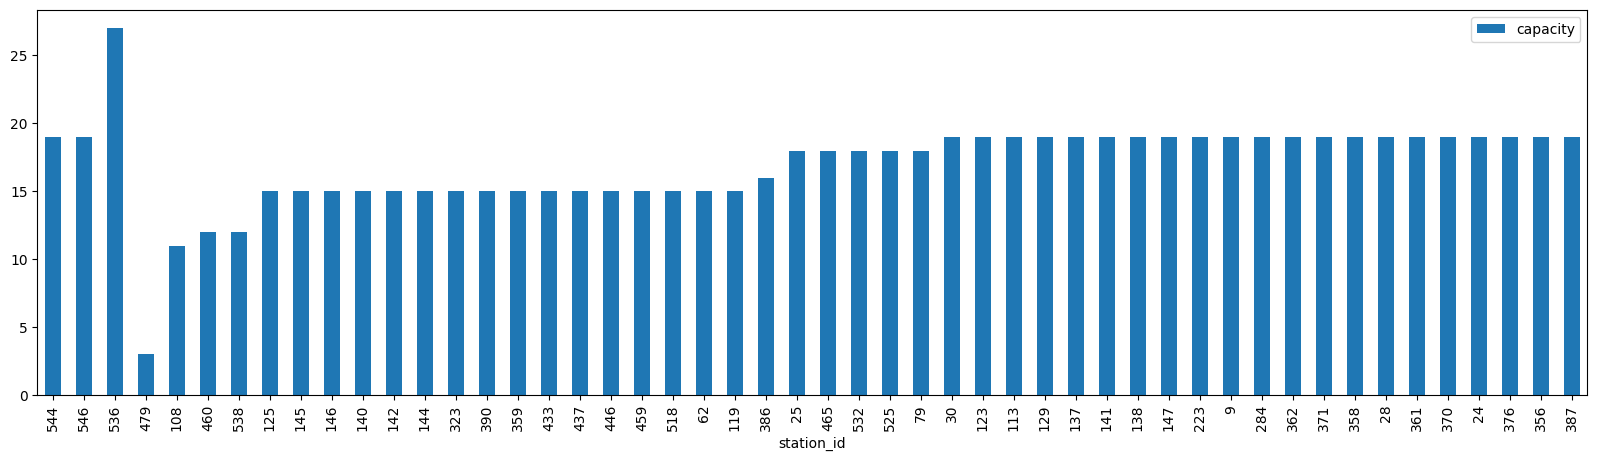

In [ ]:
# Dataset containing information about the bike station with a simple graph visualisation of capacity for the first 50 stations
df_bikeshare_station_info = df_queries[1].to_dataframe()
df_bikeshare_station_info = df_bikeshare_station_info[df_bikeshare_station_info['capacity']!=0]
df_bikeshare_station_info.iloc[:50,:].plot(kind = 'bar', x = 'station_id', y = 'capacity', figsize=(20,5))

In [ ]:
# Drawing Visualisation to show how Bike Stations are scattered on the Map
import plotly.express as px
import pandas as pd
df = pd.DataFrame(df_bikeshare_station_info, columns=["station_id", "lat", "lon"])

fig = px.scatter_mapbox(df, lat="lat", lon="lon", hover_name="station_id", zoom=5,
                        mapbox_style="carto-positron", title="Station Locations")
fig.show()

In [ ]:
# Another secondary table where status of the bike stations was captured
df_bikeshare_station_status = df_queries[2].to_dataframe()
df_bikeshare_station_status

,station_id,num_bikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,is_installed,is_renting,is_returning,last_reported,num_ebikes_available,eightd_has_available_keys
0,429a3ffa-e0df-4497-b6e9-91e3ccb12c1c,0,0,15,0,True,True,True,1697155461,0,False
1,1e5323d3-5bd3-4259-a9d4-aec0e09d8f56,0,0,21,2,True,True,True,1697155516,0,False
2,40205ede-0c43-44ab-8c9c-0d8ecd9f854e,0,0,2,0,False,False,False,1670004894,0,False
3,0d6a9101-5b40-4fdf-9315-e494af1baf7b,0,0,19,0,True,True,True,1697155549,0,False
4,a2698d11-5b7e-4421-90ed-7d7225a58a67,0,0,3,0,False,False,False,1666282405,0,False
...,...,...,...,...,...,...,...,...,...,...,...
529,dcb5ad16-caa9-4d40-b279-6d36152069a2,24,1,6,2,True,True,True,1697155543,22,False
530,ba25987f-399d-49ce-9354-52785e48ea13,32,1,6,0,True,True,True,1697155557,25,False
531,1b13a386-c5f4-42cc-bc3b-ded95982e090,33,1,2,0,True,True,True,1697155568,25,False
532,21883e7a-ea31-4cfc-843a-ca8263b39fda,29,1,4,2,True,True,True,1697155565,26,False


# Querying the primary dataset containing the trip information of the bikes

In [ ]:
# Pulling primary dataset from BigQuery and placing it into DataFrame
primary_table = 'bikeshare_trips'
query = f"SELECT * FROM `bigquery-public-data.san_francisco_bikeshare.{primary_table}`"
df_query = client.query(query)
trips_entire_data = df_query.to_dataframe()

In [ ]:
# Trying to analyse the trips data for the year 2017
import pandas as pd
trips_entire_data['start_date'] = pd.to_datetime(trips_entire_data['start_date'])
trips_entire_data['end_date'] = pd.to_datetime(trips_entire_data['end_date'])
trips_from_2017 = trips_entire_data[(trips_entire_data['start_date'].dt.year == 2017) & (trips_entire_data['end_date'].dt.year == 2017)]
trips_from_2018 = trips_entire_data[(trips_entire_data['start_date'].dt.year == 2018) & (trips_entire_data['end_date'].dt.year == 2018)]

In [ ]:
def aggregate_into_time_slots(df, year):

  df['start_date'] = pd.to_datetime(df['start_date'])
  df['start_date_only'] = df['start_date'].dt.date
  df['start_time'] = df['start_date'].dt.time

  def categorize_time_slot(time):
      time_slots = [("02:00:00", "06:00:00"), ("06:00:00", "10:00:00"), ("10:00:00", "14:00:00"),
                    ("14:00:00", "18:00:00"), ("18:00:00", "22:00:00"), ("22:00:00", "02:00:00")]
      for index, (start, end) in enumerate(time_slots):
          if start <= str(time) < end:
              return index
      return 5

  df['time_slot'] = df['start_time'].apply(categorize_time_slot)
  aggregated_data = df.groupby(['start_station_id', 'start_date_only', 'time_slot']).size().reset_index(name='trip_count')
  aggregated_data = aggregated_data[aggregated_data['trip_count'].notna()]
  aggregated_data['start_date_only'] = pd.to_datetime(df['start_date'])
  aggregated_data['isWeekday'] = aggregated_data['start_date_only'].dt.dayofweek < 5
  aggregated_data['isPeakHour'] = aggregated_data['time_slot'].isin([1, 3])
  #aggregated_data.to_csv(f"daily_aggregated_data_{year}.csv", index=False)
  return aggregated_data


In [ ]:
aggregate_trips_2017, aggregate_trips_2018  = aggregate_into_time_slots(trips_from_2017, '2017'), aggregate_into_time_slots(trips_from_2018, '2018')

<ipython-input-10-e4c5c6f5217f>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-10-e4c5c6f5217f>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-10-e4c5c6f5217f>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-10-e4c5c6f

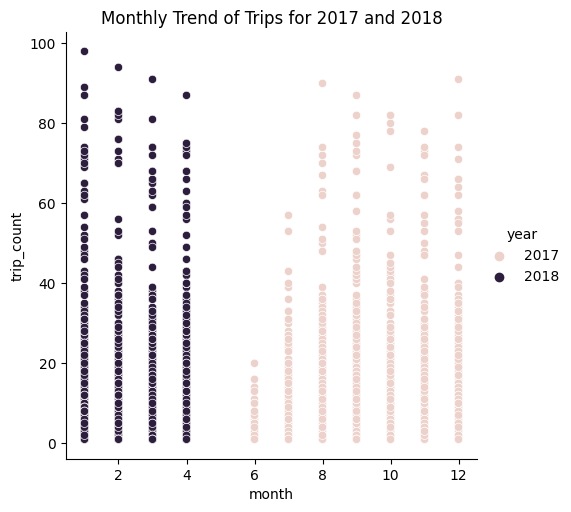

<Figure size 640x480 with 0 Axes>

In [ ]:
#What is the monthly trend of trips in 2017 and 2018?

import seaborn as sns
import matplotlib.pyplot as plt

combined_data = pd.concat([aggregate_trips_2017, aggregate_trips_2018])
combined_data['month'] = combined_data['start_date_only'].dt.month
combined_data['year'] = combined_data['start_date_only'].dt.year
combined_data = combined_data[combined_data['year'].notna()].astype(int)
sns.relplot(x='month', y='trip_count', hue='year', data=combined_data)
plt.title("Monthly Trend of Trips for 2017 and 2018")
plt.show()
plt.savefig("figure1.svg")

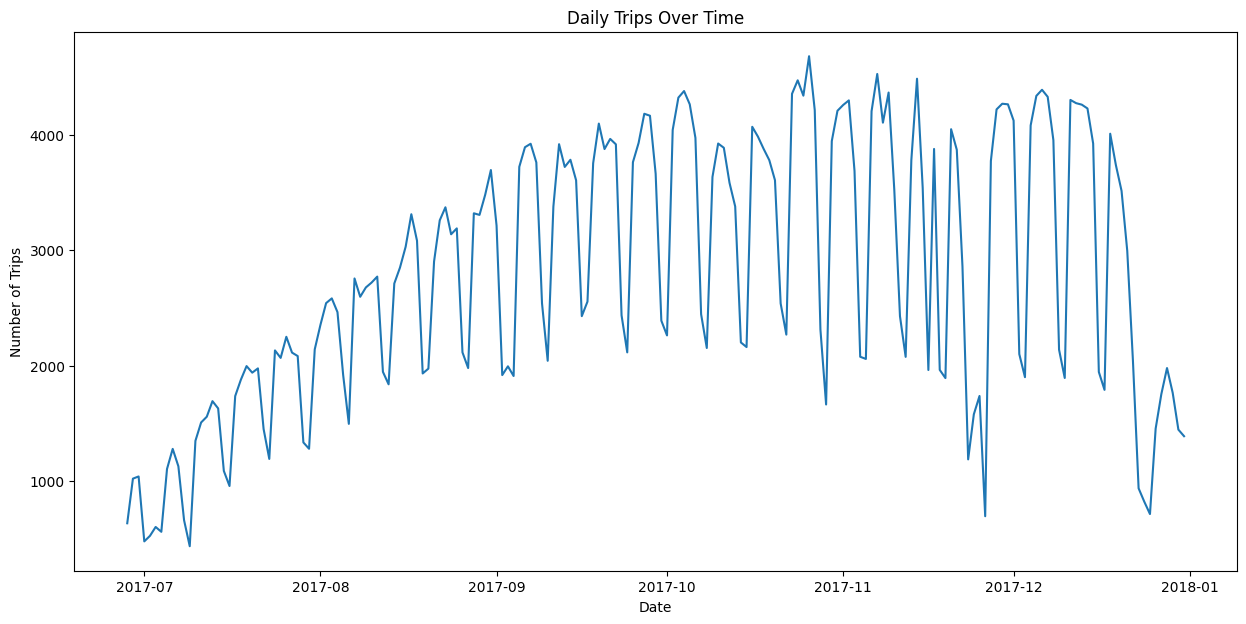

<Figure size 640x480 with 0 Axes>

In [ ]:
#How the number of trips vary throughout 2017 for different days?

import matplotlib.pyplot as plt
daily_trips = trips_from_2017.groupby(trips_from_2017['start_date'].dt.date).size()
daily_trips.plot(figsize=(15,7))
plt.title('Daily Trips Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.show()
plt.savefig("figure2.svg")

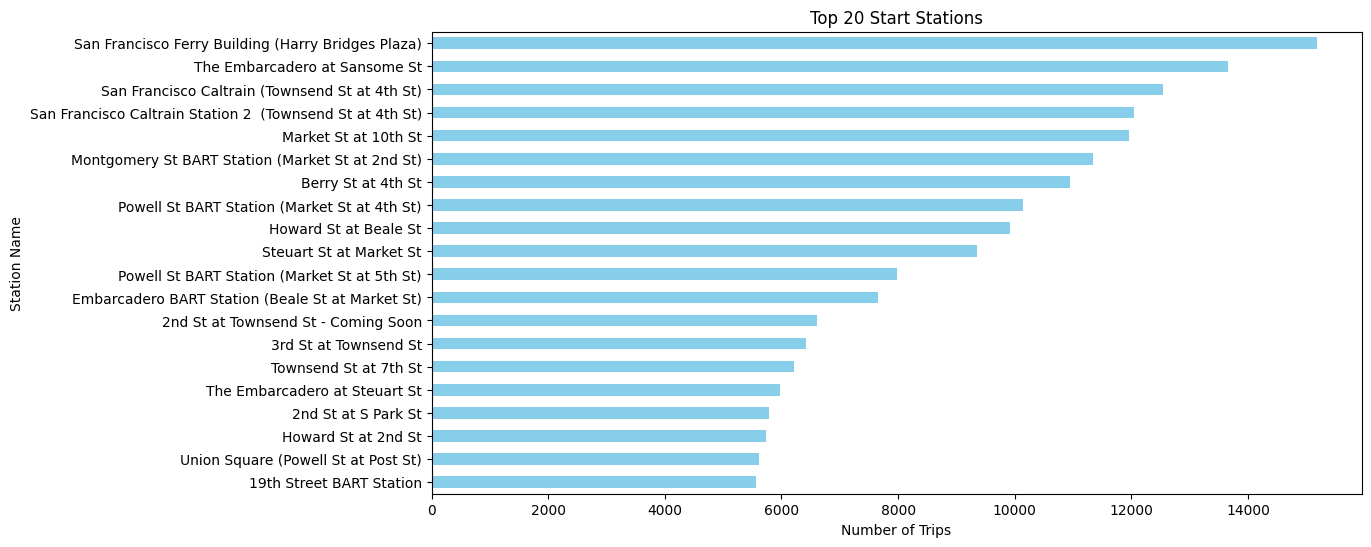

<Figure size 640x480 with 0 Axes>

In [ ]:
# What are the top 20 most popular Start Stations?

popular_starts = trips_from_2017['start_station_name'].value_counts().head(20)

plt.figure(figsize=(12, 6))
popular_starts.plot(kind='barh', color='skyblue')
plt.title('Top 20 Start Stations')
plt.xlabel('Number of Trips')
plt.ylabel('Station Name')
plt.gca().invert_yaxis()  # To display the station with the highest count at the top
plt.show()
plt.savefig("figure3.svg")

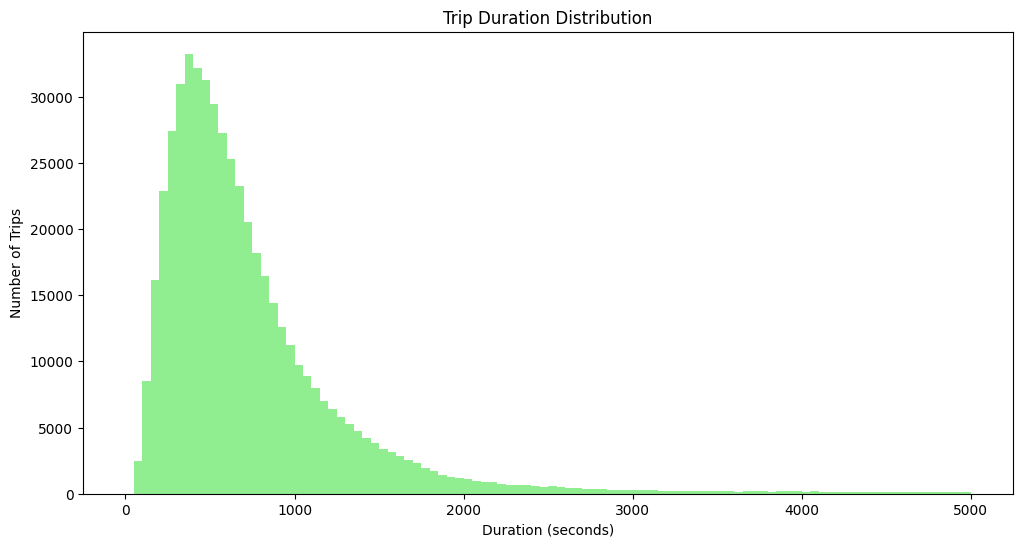

<Figure size 640x480 with 0 Axes>

In [ ]:
# What is the trip duration distribution in 2017?

plt.figure(figsize=(12, 6))
plt.hist(trips_from_2017['duration_sec'], bins=100, color='lightgreen', range=[0, 5000])
plt.title('Trip Duration Distribution')
plt.xlabel('Duration (seconds)')
plt.ylabel('Number of Trips')
plt.show()
plt.savefig("figure4.svg")

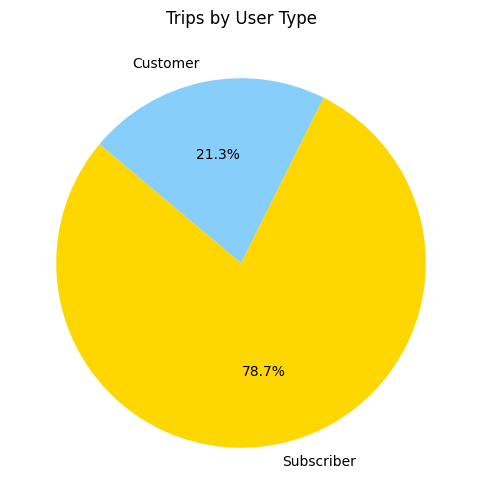

<Figure size 640x480 with 0 Axes>

In [ ]:
# Compare the Percentage of trips made by subscribers vs. regular customers.

user_types = trips_from_2017['subscriber_type'].value_counts()

plt.figure(figsize=(8, 6))
user_types.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=['gold', 'lightskyblue'])
plt.title('Trips by User Type')
plt.ylabel('')
plt.show()
plt.savefig("figure5.svg")

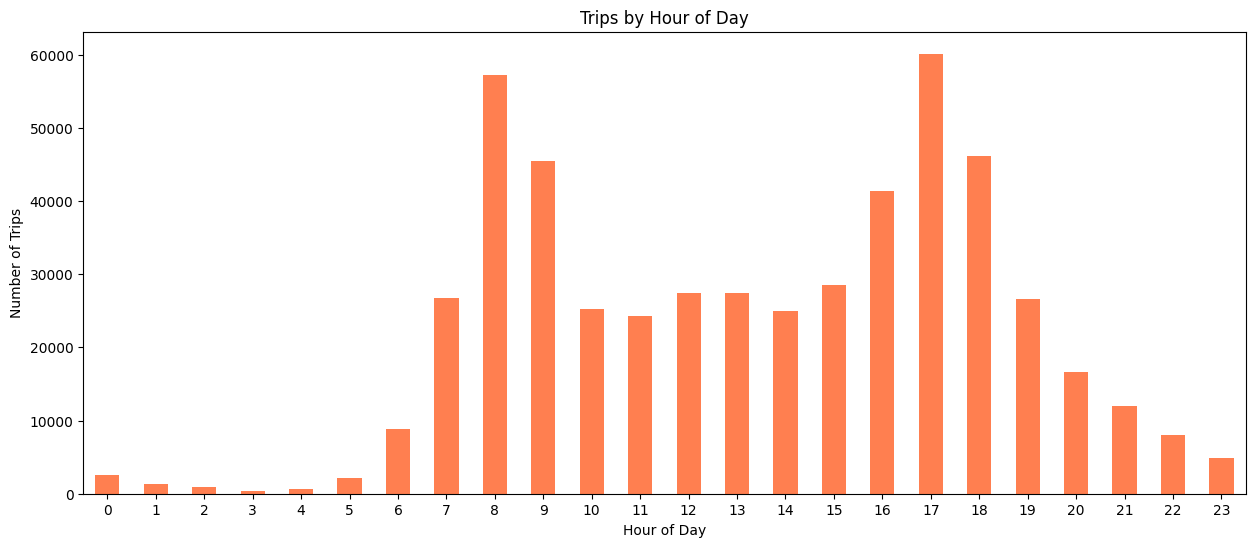

<Figure size 640x480 with 0 Axes>

In [ ]:
# What are the Total number of trips in 2017 per hour of the day?

hourly_trips = trips_from_2017.groupby(trips_from_2017['start_date'].dt.hour).size()

plt.figure(figsize=(15, 6))
hourly_trips.plot(kind='bar', color='coral')
plt.title('Trips by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.xticks(rotation=0)
plt.show()
plt.savefig("figure6.svg")


In [ ]:
from pandas_gbq import to_gbq
# BigQuery parameters
project_id = 'serious-sylph-400401'
dataset_id = 'Dataset1'

# Send the DataFrame to BigQuery
to_gbq(trips_from_2017, f"{dataset_id}.Table2", project_id=project_id, if_exists='replace')
to_gbq(aggregate_trips_2017, f"{dataset_id}.Table3", project_id=project_id, if_exists='replace')
to_gbq(combined_data, f"{dataset_id}.Table4", project_id=project_id, if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 1728.18it/s]
